# Objective
#### Determine whether the given reviews are positive or negative using all features except SCORE and then check the accuracy using the Score feature using KNN classifier

# 1. Loading data from dataset

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
import nltk
import seaborn as sns
from tqdm import tqdm

In [2]:
# Loading data from sqlite3 database ignoring those having rewiew score = 3

connection = sqlite3.connect('./database.sqlite')
dataset = pd.read_sql_query("SELECT * FROM Reviews WHERE Score != 3", connection)

In [3]:
print("The shape of the data in dataset is:", dataset.shape)
print('==' * 60)
dataset.columns                # This will list all the features name in dataset column-wise

The shape of the data in dataset is: (525814, 10)


Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

In [4]:
# Assigning Positive value to reviews with score>3 and Negative value to reviews with score<3

def assign_pn(score):
    if (score > 3):
        score = 'Positive'
    elif (score < 3):
        score = 'Negative'
    return score

pn = dataset['Score']
pn_assign = pn.map(assign_pn)
dataset['Score'] = pn_assign

In [5]:
print(dataset['Score'].value_counts() )                       # Printing the number of each classes (positive and negative reviews)
print('==' * 60)
print("The shape of the data in dataset is:", dataset.shape)

Positive    443777
Negative     82037
Name: Score, dtype: int64
The shape of the data in dataset is: (525814, 10)


In [6]:
# Printing first few rows as a sample of the dataset
# You may pass the number of rows to be displayed as an argument to the head() method

dataset.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,Positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,Negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,Positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,Negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,Positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


# 2. Pre-processing of data

### 2.1 De-duplication of data

In [7]:
# Sorting data based on ProductId

sorted_data = dataset.sort_values('ProductId', ascending=True, axis=0)
sorted_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,Positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,Positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc..."
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,Positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...
138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,Positive,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...
138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,Positive,1018396800,A great way to learn the months,This is a book of poetry about the months of t...


In [8]:
# Remove all the data points that exactly match the field values mention below

data = sorted_data.drop_duplicates(subset={'UserId', 'Time', 'Text'}, keep='first', inplace=False)
data.shape

(364133, 10)

In [9]:
# Check what percentage of original data is remaining

percentage = (data.shape[0] / dataset.shape[0]) * 100
print(percentage)

69.25129418387492


In [10]:
# Removing the reviews having HelpfulnessNumerator greater than HelpfulnessDenominator

data = data[data.HelpfulnessDenominator >= data.HelpfulnessNumerator]
data.shape

(364131, 10)

Positive    307026
Negative     57105
Name: Score, dtype: int64

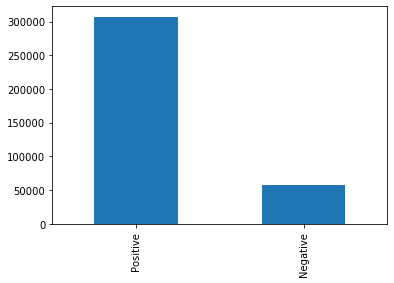

In [11]:
# Getting the number of positive and negative reviews

data['Score'].value_counts().plot(kind='bar')
data['Score'].value_counts()

### 2.2 Data Cleaning

In [12]:
import re
import string
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer

In [13]:
# Find sentences containing html tags

i = 0
for sentence in data['Text'].values:
    if (len(re.findall('<.*?>', sentence))):
        print("Total number of html tags present:", i)
        print("=="*60)
        print(sentence)
        break
    i += 1

Total number of html tags present: 6
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [14]:
# Function to remove texts with html tags(<...>)

def cleanHtml(sentence):
    cleanr = re.compile('<.*?>')                  # Select ANY text with < > tags
    cleanText = re.sub(cleanr, ' ', sentence)     # Replace texts enclosed in < > with white space
    return cleanText

In [15]:
# Function to remove punctuation marks(.,?/:;)

def cleanPunctuation(sentence):
    cleanp = re.sub(r'[?|$|.|!]',r'', sentence)
    cleanp = re.sub(r'[.|,|)|(|\|/]',r' ', cleanp)
    return cleanp

In [16]:
# Printing the set of stop words present in english language
# You need to download stopword first before using it(import nltk; nltk.download("stopwords");)

stopWords = set(stopwords.words('english'))
print(stopWords)

{"you'd", "you're", 'weren', 'haven', 'by', 'doesn', 'does', 'wouldn', 'after', 'which', "didn't", 'its', 'here', 'd', 'few', 'that', 'couldn', 'own', 'i', 'he', 'why', "wouldn't", 'me', 'of', 'doing', 'your', 'his', 'than', 'about', 'each', 'this', 'under', 'as', 'who', 'had', 'more', 'm', 'yours', 'don', 'while', 'during', 'my', 'any', 'but', 'it', 'then', 'all', 'at', 'been', 'herself', 'isn', 'needn', 'once', 'until', 'further', 'other', 'should', 'we', 'aren', 'below', 'between', 'in', 'is', 'no', 'can', 'to', 'down', 'how', 'just', 'himself', "that'll", 'and', 'for', 'out', 'did', 'ain', 'themselves', 'shan', 'theirs', 'off', 'or', 'wasn', 'shouldn', 'above', "aren't", 'myself', "hadn't", 'against', 'same', 'was', 'before', "mightn't", "hasn't", "she's", 'whom', 'are', 'has', "doesn't", "mustn't", "shan't", 'him', 'am', 'you', "haven't", 'mightn', 'some', 'itself', 'with', "wasn't", 'have', 'her', 'yourself', 'do', 'both', 'through', 'only', 'too', 'hers', 'being', 'now', 've', '

In [17]:
# Initializing SnowBall Stemmer

snowball = SnowballStemmer('english')

In [18]:
# Printing a base-word using snowball stemmer

print(snowball.stem('tasty'))
print(snowball.stem('delicious'))
print(snowball.stem('little'))

tasti
delici
littl


In [19]:
# Core Pre-processing code step-by-step(removing html tags, punctuations, stopwords, etc)
# This may take a few minutes to execute as it needs to execute all the sentences present in data['Text']

i = 0
initial_str = ''
final_str = []          # Store final string of clean words
positive_words = []     # Store words from positive reviews here
negative_words = []     # Store words from negative reviews here
s = ''

for sentence in tqdm(data['Text'].values):
    filtered_sentence = []
    sentence = cleanHtml(sentence)          # Remove html tags
    for words in sentence.split():
        for word in cleanPunctuation(words).split():
            if ((word.isalpha()) & (len(word) > 2)):
                if (word.lower() not in stopWords):
                    s = (snowball.stem(word.lower()).encode('utf-8'))
                    filtered_sentence.append(s)
                    if ((data['Score'].values)[i] == 'Positive'):
                        positive_words.append(s)
                    if ((data['Score'].values)[i] == 'Negative'):
                        negative_words.append(s)
                else:
                    continue
            else:
                continue
    initial_str = b" ".join(filtered_sentence)      # Final string of clean words
    final_str.append(initial_str)
    i += 1

100%|██████████| 364131/364131 [05:10<00:00, 1173.42it/s]


In [20]:
# Adding a column in dataset and storing cleaned text in it.

data['CleanedText'] = final_str
data['CleanedText'] = data['CleanedText'].str.decode("utf-8")

In [21]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,Positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,Positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew read sendak book watch realli rosi movi i...
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,Positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn month year learn poem t...
138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,Positive,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,great littl book read nice rhythm well good re...
138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,Positive,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,book poetri month year goe month cute littl po...


# 3. Time-based splitting of data

In [22]:
# Sorting data based on time

time_sort = data.sort_values('Time', ascending=True, axis=0, na_position='last')       # na_postion='last' puts NaNs at the end
time_sort.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,Positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,Positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...
417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,Positive,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...
346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,Positive,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...
417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,Positive,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...


In [23]:
from sklearn.model_selection import train_test_split

In [24]:
# Splitting data into Train, Test and Cross-validation

X = time_sort['CleanedText']
Y = time_sort['Score']

x_training, x_test, y_training, y_test= train_test_split(X, Y, test_size=0.25)
x_train, x_cv, y_train, y_cv = train_test_split(x_training, y_training, test_size=0.3)

In [25]:
print("The shape of the training data is:", x_train.shape, y_train.shape)
print("The shape of the CV data is:", x_cv.shape, y_cv.shape)
print("The shape of the test data is:", x_test.shape, y_test.shape)

The shape of the training data is: (191168,) (191168,)
The shape of the CV data is: (81930,) (81930,)
The shape of the test data is: (91033,) (91033,)


# 4. Function to Train and Test Decision Tree models

In [26]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

### 4.1 Train function for Decision Tree models

In [27]:
def dt_train(x_train, x_cv, y_train, y_cv):
    samples = [5, 10, 50, 100, 500]
    depth = [5, 10, 50, 100]
    accuracy_cv = []

    for i in samples:
        for j in depth:
            dt = DecisionTreeClassifier(min_samples_split=i, max_depth=j)
            dt.fit(x_train, y_train)

            prediction = dt.predict(x_cv)

            acc_cv = accuracy_score(y_cv, prediction)
            f1_cv = f1_score(y_cv, prediction, average='macro')
            precision_cv = precision_score(y_cv, prediction, average='macro')
            recall_cv = recall_score(y_cv, prediction, average='macro')

            print("FOR samples =", i, "and depth =", j)
            print("The accuracy of the model is:", acc_cv*100)
            print("The f1_score of the model is:", f1_cv*100)
            print("The precision_score of the model is:", precision_cv*100)
            print("The recall_score of the model is:", recall_cv*100)
            print("=="*60)

            accuracy_cv.append(acc_cv)

    # Plot Hyperparameters(samples/depth) vs auc_score graph
#     plt.plot(samples, accuracy_cv, 'b-', label="Samples")
#     plt.plot(depth, accuracy_cv, 'r-', label="Depth")
#     plt.legend(loc='lower right')
#     plt.title("Hyperparameters(Samples/Depth) v/s Auc Score")
#     plt.ylabel('Auc Score')
#     plt.xlabel('Samples/Depth')
#     plt.show()
    
    # Plot Heatmap for accuracy score
    cmap=sns.color_palette()
    print("---------- Representation of CV Accuracy Score in Heatmap ----------")
    accuracy_cv = np.array(accuracy_cv)
    accuracy_cv = accuracy_cv.reshape(len(depth), len(samples))
    plt.figure(figsize=(10, 5))
    sns.heatmap(accuracy_cv, annot=True, cmap=cmap, fmt=".4f", xticklabels=samples, yticklabels=depth)
    plt.xlabel('Samples')
    plt.ylabel('Depth')
    plt.show()

### 4.2 Test function for Decision Tree models

In [28]:
from sklearn.metrics import classification_report
from scikitplot.metrics import plot_confusion_matrix

In [29]:
def dt_test(x_train, y_train, x_test, y_test, optimal_samples, optimal_depth):
    dt = DecisionTreeClassifier(min_samples_split=optimal_samples, max_depth=optimal_depth)
    dt.fit(x_train, y_train)
    
    prediction = dt.predict(x_test)

    print("The accuracy of the model is:", accuracy_score(y_test, prediction)*100)
    print("The macro f1_score of the model is:", f1_score(y_test, prediction, average = 'macro')*100)
    print("The micro f1_score of the model is:", f1_score(y_test, prediction, average = 'micro')*100)
    print("The precision_score of the model is:", precision_score(y_test, prediction, average='macro')*100)
    print("The recall_score of the model is:", recall_score(y_test, prediction, average='macro')*100)
    print("The precision recall report for data:\n", classification_report(y_test, prediction))
    
    plot_confusion_matrix(y_test, prediction)
    plt.show()

### 4.3 Top 20 Features of Decision Tree models

In [30]:
from wordcloud import WordCloud

In [31]:
def top_features(x_train, y_train, vectorizer, optimal_samples, optimal_depth):
    n = 20
    features = []
    all_features = vectorizer.get_feature_names()
    model = DecisionTreeClassifier(min_samples_split=optimal_samples, max_depth=optimal_depth)
    model.fit(x_train, y_train)
    coefs = sorted(zip(model.feature_importances_, all_features))
    top = coefs[:-(n + 1):-1]
    
    print('\033[1m' + "Feature Importance \t Features" + '\033[0m')
    print("="*35)
    for (coef1, feat1) in top:
        print("%.4f\t\t\t%-2s" % (coef1, feat1))
        features.append(feat1)
    
    wordcloud = WordCloud(background_color='black', width=1600, height=800).generate(" ".join(features))
    fig = plt.figure(figsize=(30, 20))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()

### 4.4 Graphical Visualization of Decision Tree models

In [33]:
from sklearn import tree

In [34]:
def construct_tree(x_train, y_train, vectorizer, optimal_samples, optimal_depth):
    all_features = vectorizer.get_feature_names()
    model = tree.DecisionTreeClassifier(max_depth=optimal_depth, min_samples_split=optimal_samples, random_state=0)
    model.fit(x_train, y_train)
    plt.figure(figsize=(12,12))
    tree.plot_tree(model, feature_names=all_features, max_depth=2, fontsize=10)
    plt.title("Decision Tree on Amazon Fine Food Reviews (Gini)")
    # Here we set the depth to 2 and not optimal_depth because the tree with large depth becomes mess to display

# 5. Vectorization of splitted of data

### 5.1 Bag of Words (BoW)

In [35]:
from sklearn.feature_extraction.text import CountVectorizer

In [36]:
count_vect = CountVectorizer(ngram_range=(1,2))
count_vect.fit(x_train)
# Fit should be done only to train data
# After fitting count_vect only learns the vocabulary of x_train i.e unique words(unique n-grams)

# To convert the SENTENCE into numerical vectors, we call transform()
x_train_bow = count_vect.transform(x_train)
x_cv_bow = count_vect.transform(x_cv)
x_test_bow = count_vect.transform(x_test)

In [37]:
print("The shape of the training data is:", x_train_bow.shape, y_train.shape)
print("The shape of the CV data is:", x_cv_bow.shape, y_cv.shape)
print("The shape of the test data is:", x_test_bow.shape, y_test.shape)

The shape of the training data is: (191168, 1929444) (191168,)
The shape of the CV data is: (81930, 1929444) (81930,)
The shape of the test data is: (91033, 1929444) (91033,)


### 5.2 Term Frequency - Inverse Document Frequency (tf-idf)

In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [37]:
tfidf_vect = TfidfVectorizer(stop_words=None, ngram_range=(1,2))
tfidf_vect.fit(x_train)
# Fit should be done only to train data
# After fitting tfidf_vect only learnss the vocabulary of x_train i.e unique words(unique n-grams)

# To convert the SENTENCE into numerical vectors, we call transform()
x_train_tfidf = tfidf_vect.transform(x_train)
x_cv_tfidf = tfidf_vect.transform(x_cv)
x_test_tfidf = tfidf_vect.transform(x_test)

In [38]:
print("The shape of the training data is:", x_train_tfidf.shape, y_train.shape)
print("The shape of the CV data is:", x_cv_tfidf.shape, y_cv.shape)
print("The shape of the test data is:", x_test_tfidf.shape, y_test.shape)

The shape of the training data is: (191168, 1927607) (191168,)
The shape of the CV data is: (81930, 1927607) (81930,)
The shape of the test data is: (91033, 1927607) (91033,)


### 5.3 Word2Vec

In [39]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

In [40]:
sentence_list = []
for sentence in x_train:
    sentence_list.append(sentence.split())

In [41]:
sentence_list_cv = []
for sentence in x_cv:
    sentence_list_cv.append(sentence.split())

In [42]:
sentence_list_test = []
for sentence in x_test:
    sentence_list_test.append(sentence.split())

In [43]:
# Train your own Word2Vec model using your own train text corpus 

w2v_train_model = Word2Vec(sentence_list, min_count=5, size=50, workers=4)          # Considers only those words that occured atleast 5 times
print(type(w2v_train_model))

<class 'gensim.models.word2vec.Word2Vec'>


In [44]:
w2v_words = list(w2v_train_model.wv.vocab)
print("The number of words that occured minimum 5 times:", len(w2v_words))
print("These are the sample words from index 0 to 50:/n", w2v_words[0:50])

The number of words that occured minimum 5 times: 16400
These are the sample words from index 0 to 50:/n ['intrigu', 'particular', 'blend', 'got', 'exot', 'name', 'disappoint', 'ever', 'slight', 'coconut', 'aftertast', 'make', 'delici', 'like', 'strong', 'coffe', 'perfect', 'husband', 'get', 'send', 'regular', 'one', 'favorit', 'second', 'jamaica', 'crazi', 'wolfgang', 'puck', 'much', 'tastier', 'brand', 'syrup', 'cassi', 'hard', 'find', 'peopl', 'settl', 'creme', 'alcohol', 'base', 'overwhelm', 'wine', 'black', 'tiger', 'far', 'best', 'tast', 'keurig', 'machin', 'work']


### 5.4 Average Word2Vec

In [45]:
avg_train_vector = []                         # Average w2v for each review/sentence is stored in this array
for sentence in tqdm(sentence_list):          # For each sentence/review
    sentence_vector = np.zeros(50)            # As word vectors are of zero length
    count_words = 0                           # Num of words with a valid vector in a sentence/review
    for word in sentence:
        try:
            vect = w2v_train_model.wv[word]
            sentence_vector += vect
            count_words += 1
        except:
            pass
    if count_words != 0:
        sentence_vector /= count_words
    avg_train_vector.append(sentence_vector)
avg_train_vector = np.array(avg_train_vector)

100%|██████████| 191168/191168 [00:20<00:00, 9296.44it/s]


In [46]:
print(avg_train_vector.shape)
print(avg_train_vector[0])

(191168, 50)
[ 1.20688062  0.64512726 -0.07627227  0.54305566 -0.06266509 -0.95355429
  0.52486759 -0.18705197  0.6154496  -0.68326797 -0.49055745 -0.6883293
  0.75140465 -0.4618942  -0.12482487 -1.00005163  0.12876358  0.39240057
 -0.39915657  0.22415694  0.56359041 -0.08267223 -1.30383755  0.94316357
 -0.32308726 -0.66932689 -0.22714038  0.39176974  0.33780735 -0.4725275
 -0.23307023 -0.30592994  0.24653264 -0.65664214 -0.1076602  -0.40868391
  0.02556841 -0.56600711  0.05828619  0.02430611 -0.24775038 -0.02985628
 -0.00557915  0.42976616  0.42091353  0.58154343  0.5215433  -0.85581296
 -0.02849669  0.17748459]


In [47]:
avg_cv_vector = []                            # Average w2v for each review/sentence is stored in this array
for sentence in tqdm(sentence_list_cv):       # For each sentence/review
    sentence_vector = np.zeros(50)            # As word vectors are of zero length
    count_words = 0                           # Num of words with a valid vector in a sentence/review
    for word in sentence:
        try:
            vect = w2v_train_model.wv[word]
            sentence_vector += vect
            count_words += 1
        except:
            pass
    if count_words != 0:
        sentence_vector /= count_words
    avg_cv_vector.append(sentence_vector)
avg_cv_vector = np.array(avg_cv_vector)

100%|██████████| 81930/81930 [00:08<00:00, 9375.00it/s]


In [48]:
print(avg_cv_vector.shape)
print(avg_cv_vector[0])

(81930, 50)
[-1.07014144 -0.60420689 -0.09898658  0.00707368  0.49949079  0.01844266
 -0.68224208 -0.94087752 -0.06488223  0.16716007 -0.33641971 -0.95426559
  0.53942252  0.22819879 -0.96261076  0.6562062   0.31336302  0.75887537
  0.55612116 -0.40010706 -0.98429573  0.31323204 -1.00188352  1.35669088
 -0.56998782  0.46741759 -0.19807443 -0.04187166  0.29205991  0.3121441
 -1.11556307 -0.04105221  0.73350935  0.25754156  1.4575714   0.59123325
  0.03841986  0.55323701  0.14590691 -0.87116603  0.57736328 -0.0722774
 -1.28329428 -0.42202457  0.2017079  -0.68241609 -0.60190972 -1.11527879
 -0.1795318   0.66240393]


In [49]:
avg_test_vector = []                          # Average w2v for each review/sentence is stored in this array
for sentence in tqdm(sentence_list_test):     # For each sentence/review
    sentence_vector = np.zeros(50)            # As word vectors are of zero length
    count_words = 0                           # Num of words with a valid vector in a sentence/review
    for word in sentence:
        try:
            vect = w2v_train_model.wv[word]
            sentence_vector += vect
            count_words += 1
        except:
            pass
    if count_words != 0:
        sentence_vector /= count_words
    avg_test_vector.append(sentence_vector)
avg_test_vector = np.array(avg_test_vector)

100%|██████████| 91033/91033 [00:09<00:00, 9359.23it/s]


In [50]:
print(avg_test_vector.shape)
print(avg_test_vector[0])

(91033, 50)
[-0.7167391   0.87562239 -0.34311903 -0.1617036   0.4592588  -0.30645571
 -0.45302801 -0.59576892 -0.46624317  0.0823977  -0.3301962  -0.33746818
  0.85932501  0.38371382 -0.56504968 -0.02045168  0.03848641  1.06481777
  0.20846857 -0.59835168  0.48060843 -0.03811347 -0.86595227 -0.49420151
  0.14614368  0.29358101 -0.6806834  -0.98879931  0.54319518  0.57356671
  0.17689546 -0.050268    0.38213103  0.24470349  0.71615364 -0.27025153
  0.32277353  0.16433381  0.36548321 -0.06482996  0.05625233 -0.14378445
 -0.71853736 -0.34677643  0.62325162 -0.27158201 -0.08275143 -0.13566357
 -0.8028135   0.55897338]


In [51]:
x_train_avgw2v = avg_train_vector
x_cv_avgw2v = avg_cv_vector
x_test_avgw2v = avg_test_vector

In [52]:
print("The shape of the training data is:", x_train_avgw2v.shape, y_train.shape)
print("The shape of the CV data is:", x_cv_avgw2v.shape, y_cv.shape)
print("The shape of the test data is:", x_test_avgw2v.shape, y_test.shape)

The shape of the training data is: (191168, 50) (191168,)
The shape of the CV data is: (81930, 50) (81930,)
The shape of the test data is: (91033, 50) (91033,)


### 5.5 TF-IDF Weighed Word2Vec

In [53]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [54]:
tfidf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10, max_features=500)
tfidf_vect.fit_transform(x_train)
tfidf_feat = tfidf_vect.get_feature_names()
dictionary = dict(zip(tfidf_feat, list(tfidf_vect.idf_)))

In [55]:
tfidf_train_vector = []                         # Average w2v for each review/sentence is stored in this array
for sentence in tqdm(sentence_list):            # For each sentence/review
    sentence_vector = np.zeros(50)              # As word vectors are of zero length
    weight_sum = 0                              # Num of words with a valid vector in a sentence/review
    for word in sentence:
        try:
            vect = w2v_train_model.wv[word]
            tfidf_weight = dictionary[word]*(sentence.count(word)/len(sentence))
            sentence_vector += (vect*tfidf_weight)
            weight_sum += tfidf_weight
        except:
            pass
    if weight_sum != 0:
        sentence_vector /= weight_sum
    tfidf_train_vector.append(sentence_vector)
tfidf_train_vector = np.array(tfidf_train_vector)

100%|██████████| 191168/191168 [00:44<00:00, 4323.62it/s]


In [56]:
print(tfidf_train_vector.shape)
print(tfidf_train_vector[0])

(191168, 50)
[ 1.57729647  0.42511625 -0.18760935  0.47813032 -0.04950523 -1.00938163
  0.59054142 -0.15644262  0.55549119 -0.75898192 -0.5755441  -1.22877252
  0.91790945 -0.81422871 -0.34674206 -1.18877619  0.01939398  0.62652999
 -0.54225852  0.3733967   0.43578146 -0.61624616 -1.90820692  0.63102521
 -0.46299216 -0.8688338  -0.34597475  0.43166698  0.38910194 -0.92720339
 -0.28617419 -0.39917132  0.552134   -0.60643748 -0.30092149 -0.55391397
  0.35973382 -0.65515215  0.50610728  0.06663784 -0.17344023  0.34301212
 -0.28965553  0.41370428  0.88600557  0.54407414  0.62318347 -0.72716341
 -0.19495673 -0.00928915]


In [57]:
tfidf_cv_vector = []                            # Average w2v for each review/sentence is stored in this array
for sentence in tqdm(sentence_list_cv):         # For each sentence/review
    sentence_vector = np.zeros(50)              # As word vectors are of zero length
    weight_sum = 0                              # Num of words with a valid vector in a sentence/review
    for word in sentence:
        try:
            vect = w2v_train_model.wv[word]
            tfidf_weight = dictionary[word]*(sentence.count(word)/len(sentence))
            sentence_vector += (vect*tfidf_weight)
            weight_sum += tfidf_weight
        except:
            pass
    if weight_sum != 0:
        sentence_vector /= weight_sum
    tfidf_cv_vector.append(sentence_vector)
tfidf_cv_vector = np.array(tfidf_cv_vector)

100%|██████████| 81930/81930 [00:18<00:00, 4312.51it/s]


In [58]:
print(tfidf_cv_vector.shape)
print(tfidf_cv_vector[0])

(81930, 50)
[-1.08976884 -0.6877602  -0.52792819  0.38964099  0.17008886  0.10844552
 -0.95533034 -0.88527834 -0.17113004 -0.13263469 -0.2509237  -1.32522221
  1.07512288  0.46363374 -0.82930363  0.82834878  0.05259164  1.04269753
  0.41073894  0.0257041  -1.15902485  0.33091412 -1.79780102  1.08079183
 -0.06795321  0.15251154  0.26121169  0.11334476  0.6748527   0.00436513
 -1.97030533  0.2849968   1.06167378  0.08964328  1.7264726   0.7403756
  0.26837644  0.27482426  0.42219237 -1.02160702  0.41646367  0.75943139
 -1.29252287  0.00723927  0.42599771 -0.46383576 -0.66457877 -1.44884766
 -0.23648445  0.57638617]


In [59]:
tfidf_test_vector = []                          # Average w2v for each review/sentence is stored in this array
for sentence in tqdm(sentence_list_test):       # For each sentence/review
    sentence_vector = np.zeros(50)              # As word vectors are of zero length
    weight_sum = 0                              # Num of words with a valid vector in a sentence/review
    for word in sentence:
        try:
            vect = w2v_train_model.wv[word]
            tfidf_weight = dictionary[word]*(sentence.count(word)/len(sentence))
            sentence_vector += (vect*tfidf_weight)
            weight_sum += tfidf_weight
        except:
            pass
    if weight_sum != 0:
        sentence_vector /= weight_sum
    tfidf_test_vector.append(sentence_vector)
tfidf_test_vector = np.array(tfidf_test_vector)

100%|██████████| 91033/91033 [00:21<00:00, 4321.59it/s]


In [60]:
print(tfidf_test_vector.shape)
print(tfidf_test_vector[0])

(91033, 50)
[-0.46945613  1.16459163 -0.19755934  0.22990033  0.47887047 -0.33464072
 -0.29059388 -0.38487398 -0.64157895  0.27070888 -0.73190287 -0.74747327
  0.79757943  0.15500646 -0.47384996  0.10378377  0.32479474  1.49056977
  0.22865869 -1.27428875  0.37530486  0.00286199 -1.04389724 -0.7881582
  0.58514632  0.03964756 -0.15419494 -0.85955158  0.41298593  1.03272056
 -0.25257451  0.07632891  0.3125724   0.02725759  1.16361631 -0.74786727
  0.33783359  0.53481511  0.65160738 -0.31275959  0.19870941 -0.36875986
 -1.50633763 -0.70871183  0.81522191  0.1979025  -0.05657389 -0.18652247
 -0.8906658   0.85392477]


In [61]:
x_train_tfidfw2v = tfidf_train_vector
x_cv_tfidfw2v = tfidf_cv_vector
x_test_tfidfw2v = tfidf_test_vector

In [62]:
print("The shape of the training data is:", x_train_tfidfw2v.shape, y_train.shape)
print("The shape of the CV data is:", x_cv_tfidfw2v.shape, y_cv.shape)
print("The shape of the test data is:", x_test_tfidfw2v.shape, y_test.shape)

The shape of the training data is: (191168, 50) (191168,)
The shape of the CV data is: (81930, 50) (81930,)
The shape of the test data is: (91033, 50) (91033,)


# 6. Applying Decision Tree Classifier on Our Model

### 6.1 Bag of Words (BoW)

##### 6.1.1 BoW Decision Tree on Train Data

FOR samples = 5 and depth = 5
The accuracy of the model is: 86.0563896008788
The f1_score of the model is: 61.64999908014246
The precision_score of the model is: 78.00446284530041
The recall_score of the model is: 59.18154368744419
FOR samples = 5 and depth = 10
The accuracy of the model is: 86.62638838032467
The f1_score of the model is: 64.15677847368224
The precision_score of the model is: 79.92690389368123
The recall_score of the model is: 61.036816515932024
FOR samples = 5 and depth = 50
The accuracy of the model is: 87.23056267545466
The f1_score of the model is: 71.99528022635049
The precision_score of the model is: 76.89661358880085
The recall_score of the model is: 69.20947541564857
FOR samples = 5 and depth = 100
The accuracy of the model is: 86.87294031490296
The f1_score of the model is: 72.9561999316966
The precision_score of the model is: 75.43754765877473
The recall_score of the model is: 71.15768512658008
FOR samples = 10 and depth = 5
The accuracy of the model is: 86.0

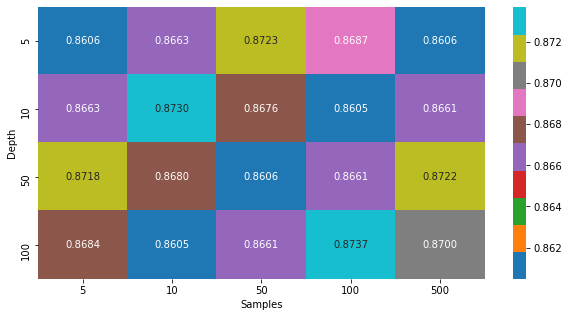

In [63]:
# Find the optimal value of depth and samples
# This may take several minutes(even hour/s) to run

dt_train(x_train_bow, x_cv_bow, y_train, y_cv)

##### 6.1.2 BoW Decision Tree on Test Data

The accuracy of the model is: 87.39358254698845
The macro f1_score of the model is: 71.97242305114386
The micro f1_score of the model is: 87.39358254698845
The precision_score of the model is: 77.4977831183944
The recall_score of the model is: 68.98564271234723
The precision recall report for data:
               precision    recall  f1-score   support

    Negative       0.65      0.42      0.51     14264
    Positive       0.90      0.96      0.93     76769

    accuracy                           0.87     91033
   macro avg       0.77      0.69      0.72     91033
weighted avg       0.86      0.87      0.86     91033



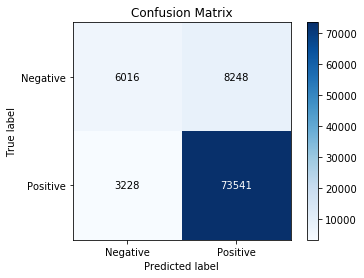

In [64]:
# Testing the final model

dt_test(x_train_bow, y_train, x_test_bow, y_test, optimal_samples=500, optimal_depth=50)

Feature Importance 	 Features
0.0921			disappoint
0.0527			wast money
0.0484			great
0.0473			return
0.0386			worst
0.0353			best
0.0352			love
0.0291			bad
0.0232			horribl
0.0228			delici
0.0196			terribl
0.0194			good
0.0191			threw
0.0179			aw
0.0162			perfect
0.0136			refund
0.0133			favorit
0.0126			unfortun
0.0112			nice
0.0107			excel


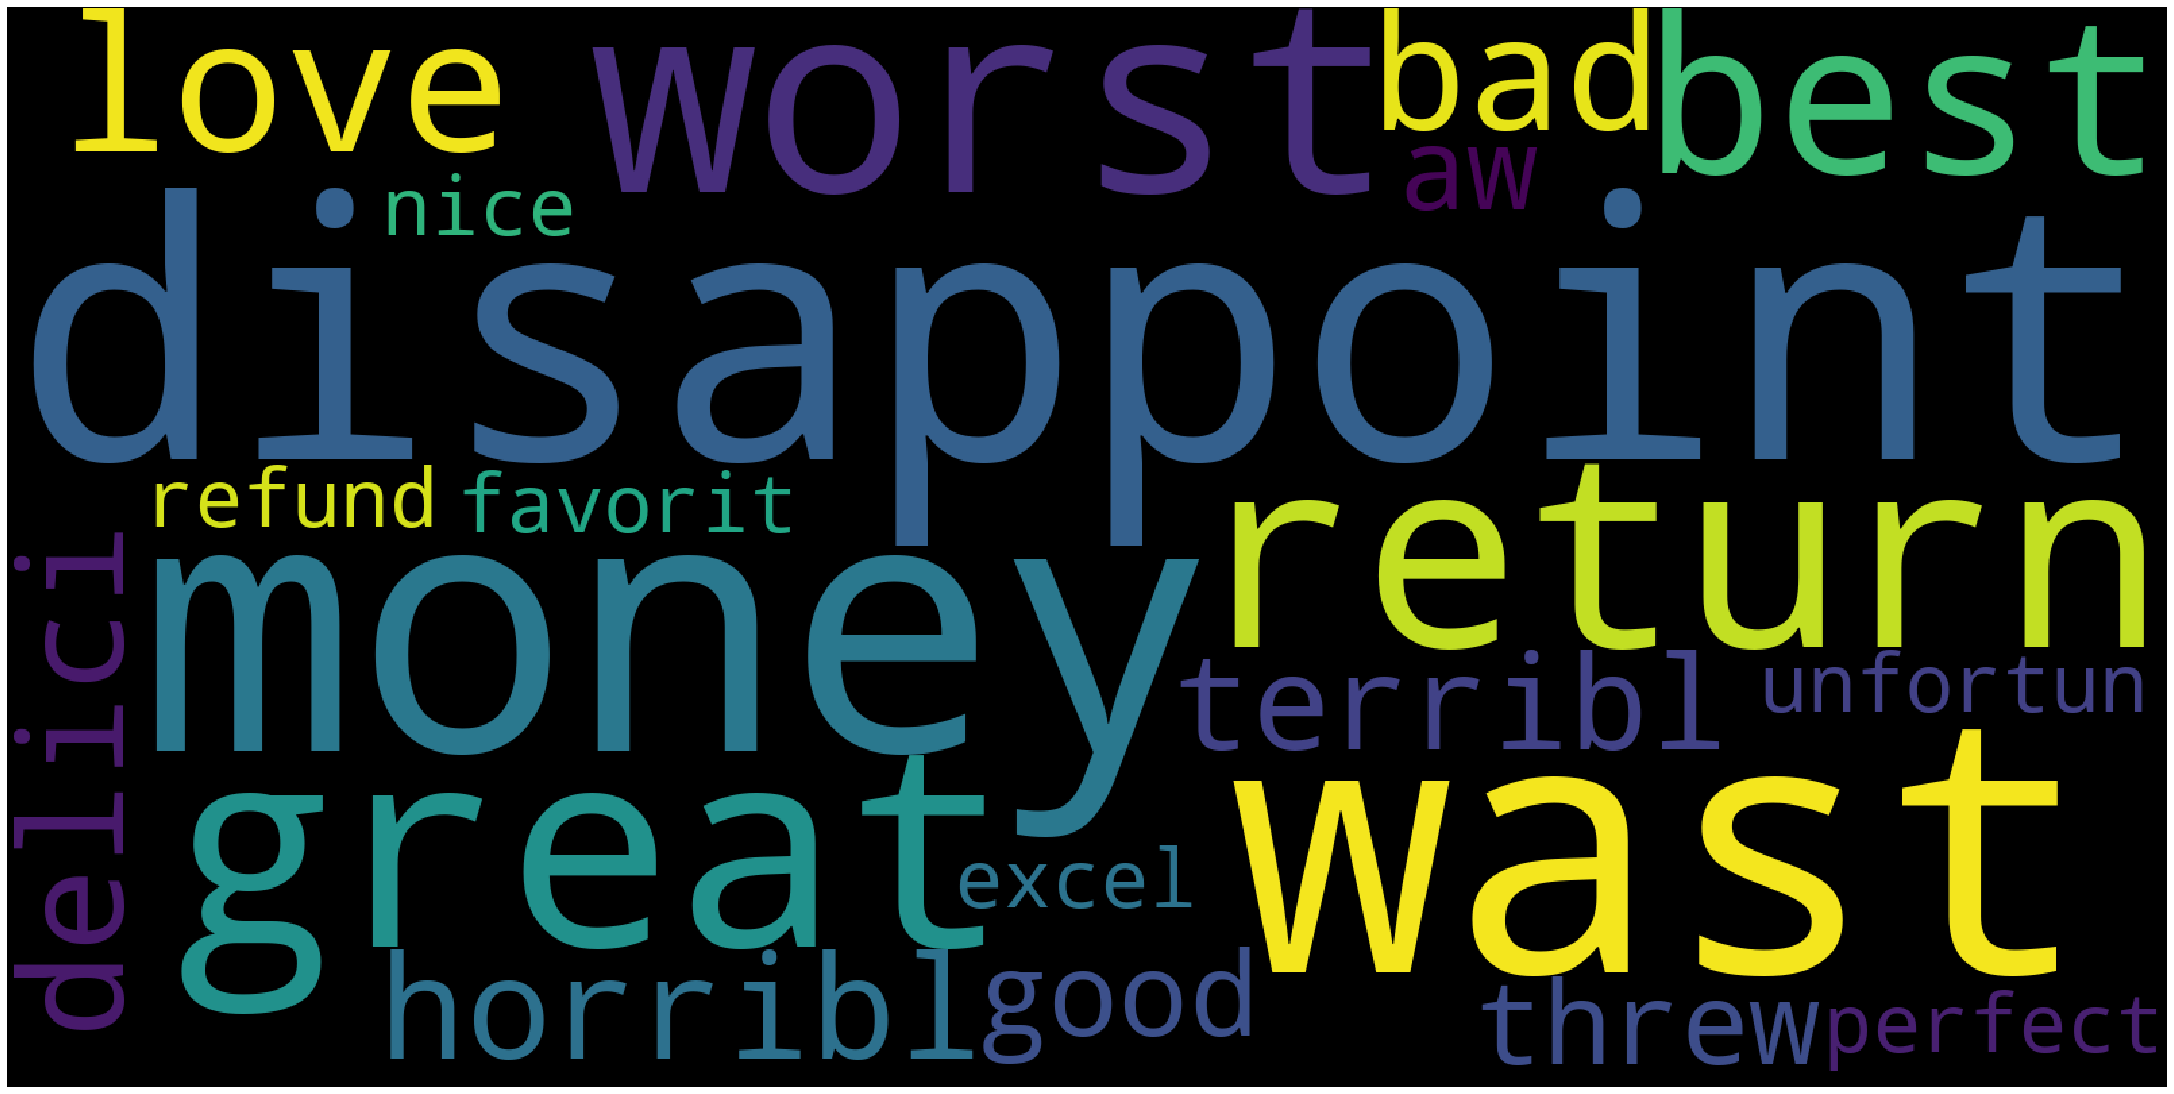

In [38]:
top_features(x_train_bow, y_train, count_vect, optimal_samples=500, optimal_depth=50)

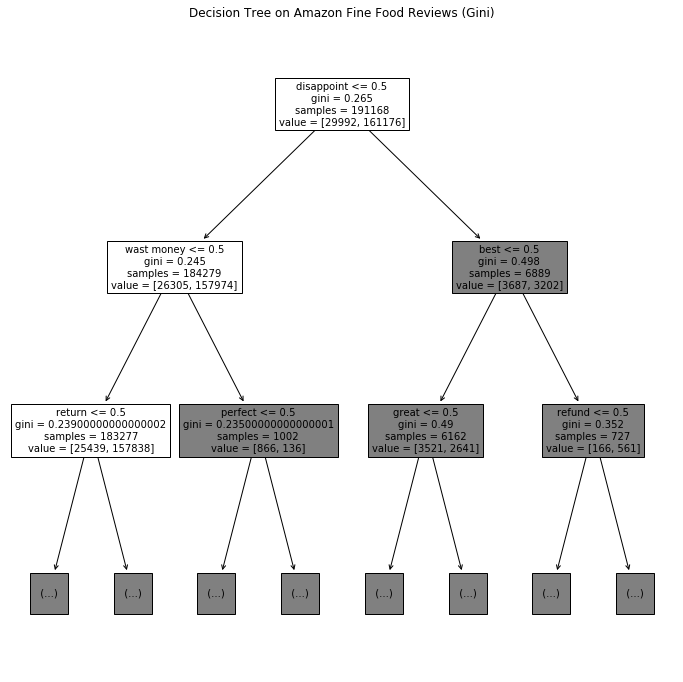

In [66]:
construct_tree(x_train_bow, y_train, count_vect, optimal_samples=500, optimal_depth=50)

### 6.2 Term Frequency - Inverse Document Frequency (tf-idf)

##### 6.2.1 TF-IDF Decision Tree on Train Data

FOR samples = 5 and depth = 5
The accuracy of the model is: 86.03441962651044
The f1_score of the model is: 61.40339203064003
The precision_score of the model is: 78.05495264313107
The recall_score of the model is: 58.997671081367685
FOR samples = 5 and depth = 10
The accuracy of the model is: 86.43598193579885
The f1_score of the model is: 62.8075137505821
The precision_score of the model is: 79.9945489807716
The recall_score of the model is: 59.98996249507654
FOR samples = 5 and depth = 50
The accuracy of the model is: 86.74722323935067
The f1_score of the model is: 71.30812240250805
The precision_score of the model is: 75.48444748375952
The recall_score of the model is: 68.82222505134611
FOR samples = 5 and depth = 100
The accuracy of the model is: 86.12352007811546
The f1_score of the model is: 71.97770929892027
The precision_score of the model is: 73.69993428855312
The recall_score of the model is: 70.63570714263035
FOR samples = 10 and depth = 5
The accuracy of the model is: 86.0

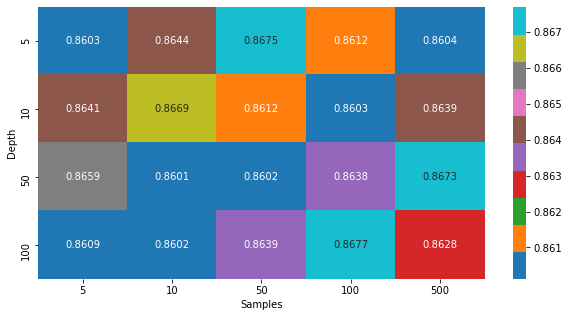

In [67]:
# Find the optimal value of depth and samples
# This may take several minutes to run

dt_train(x_train_tfidf, x_cv_tfidf, y_train, y_cv)

##### 6.2.2 TF-IDF Decision Tree on Test Data

The accuracy of the model is: 86.71690485867762
The macro f1_score of the model is: 71.16247912211247
The micro f1_score of the model is: 86.71690485867762
The precision_score of the model is: 75.6090508092033
The recall_score of the model is: 68.59174900441751
The precision recall report for data:
               precision    recall  f1-score   support

    Negative       0.61      0.42      0.50     14342
    Positive       0.90      0.95      0.92     76691

    accuracy                           0.87     91033
   macro avg       0.76      0.69      0.71     91033
weighted avg       0.85      0.87      0.86     91033



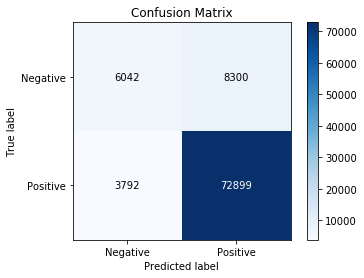

In [68]:
# Testing the final model

dt_test(x_train_tfidf, y_train, x_test_tfidf, y_test, optimal_samples=500, optimal_depth=50)

In [69]:
top_features(x_train_tfidf, y_train, tfidf_vect, optimal_samples=500, optimal_depth=50)

Feature Importance 	 Features
0.0000			yummi
0.0000			yet
0.0000			year old
0.0000			year
0.0000			would
0.0000			worth
0.0000			work
0.0000			wonder
0.0000			without
0.0000			wish
0.0000			wife
0.0000			whole
0.0000			white
0.0000			wheat
0.0000			went
0.0000			well
0.0000			weight
0.0000			week
0.0000			way
0.0000			water


### 6.3 Average word2Vec

##### 6.3.1 Avg W2V Decision Tree on Train Data

FOR samples = 5 and depth = 5
The accuracy of the model is: 86.3883803246674
The f1_score of the model is: 64.93609116475932
The precision_score of the model is: 77.29008267683125
The recall_score of the model is: 61.83133966024727
FOR samples = 5 and depth = 10
The accuracy of the model is: 86.67032832906139
The f1_score of the model is: 70.43784605078217
The precision_score of the model is: 75.51258109920569
The recall_score of the model is: 67.70873701289162
FOR samples = 5 and depth = 50
The accuracy of the model is: 82.58147198828269
The f1_score of the model is: 67.97919512242724
The precision_score of the model is: 67.51014160866902
The recall_score of the model is: 68.50687655998769
FOR samples = 5 and depth = 100
The accuracy of the model is: 82.65958745270353
The f1_score of the model is: 68.01217493662745
The precision_score of the model is: 67.59563146527059
The recall_score of the model is: 68.47397583375397
FOR samples = 10 and depth = 5
The accuracy of the model is: 86.3

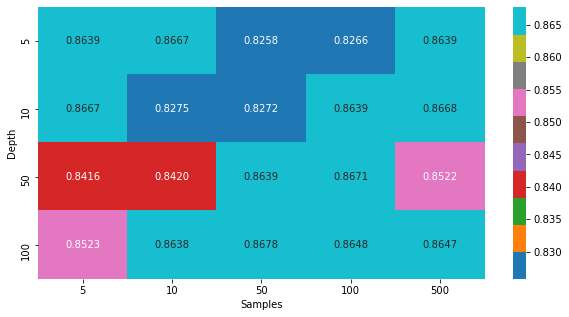

In [72]:
# Find the optimal value of depth and samples
# This may take several minutes to run

dt_train(x_train_avgw2v, x_cv_avgw2v, y_train, y_cv)

##### 6.3.2 Avg W2V Decision Tree on Test Data

The accuracy of the model is: 86.93221139586743
The macro f1_score of the model is: 69.6442219054877
The micro f1_score of the model is: 86.93221139586743
The precision_score of the model is: 77.15833171293426
The recall_score of the model is: 66.38690799127161
The precision recall report for data:
               precision    recall  f1-score   support

    Negative       0.65      0.36      0.47     14342
    Positive       0.89      0.96      0.93     76691

    accuracy                           0.87     91033
   macro avg       0.77      0.66      0.70     91033
weighted avg       0.85      0.87      0.85     91033



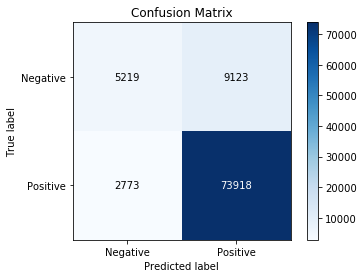

In [74]:
# Testing the final model

dt_test(x_train_avgw2v, y_train, x_test_avgw2v, y_test, optimal_samples=500, optimal_depth=10)

### 6.4 TF-IDF Weighed Word2Vec

##### 6.4.1 TF-IDF W2V Decision Tree on Train Data

FOR samples = 5 and depth = 5
The accuracy of the model is: 84.71744171854021
The f1_score of the model is: 54.06045788936691
The precision_score of the model is: 71.4832842018033
The recall_score of the model is: 54.16382941194319
FOR samples = 5 and depth = 10
The accuracy of the model is: 84.36958379104114
The f1_score of the model is: 61.84147511882979
The precision_score of the model is: 68.72138615307868
The recall_score of the model is: 59.80720181188388
FOR samples = 5 and depth = 50
The accuracy of the model is: 78.91614793116075
The f1_score of the model is: 61.592856232086156
The precision_score of the model is: 61.210310580785624
The recall_score of the model is: 62.05556121975082
FOR samples = 5 and depth = 100
The accuracy of the model is: 78.99182228731844
The f1_score of the model is: 61.7991216736825
The precision_score of the model is: 61.39328075503996
The recall_score of the model is: 62.29373144308917
FOR samples = 10 and depth = 5
The accuracy of the model is: 84.

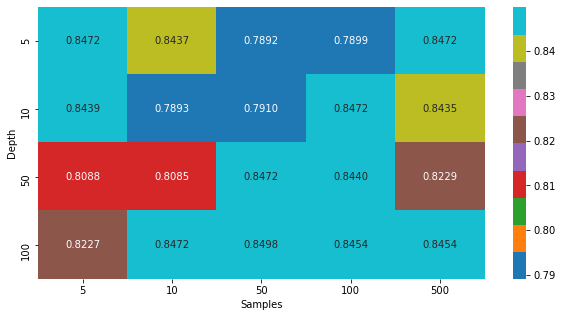

In [75]:
# Find the optimal value of depth and samples
# This may take several minutes to run

dt_train(x_train_tfidfw2v, x_cv_tfidfw2v, y_train, y_cv)

##### 6.4.2 TF-IDF W2V Decision Tree on Test Data

The accuracy of the model is: 84.94282293234322
The macro f1_score of the model is: 60.87966570913861
The micro f1_score of the model is: 84.9428229323432
The precision_score of the model is: 71.36336370607594
The recall_score of the model is: 58.817690040297954
The precision recall report for data:
               precision    recall  f1-score   support

    Negative       0.56      0.21      0.30     14342
    Positive       0.87      0.97      0.92     76691

    accuracy                           0.85     91033
   macro avg       0.71      0.59      0.61     91033
weighted avg       0.82      0.85      0.82     91033



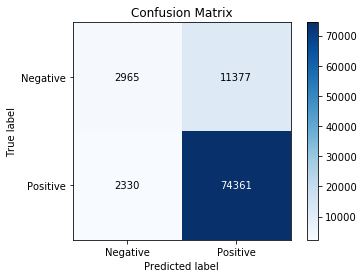

In [76]:
# Testing the final model

dt_test(x_train_tfidfw2v, y_train, x_test_tfidfw2v, y_test, optimal_samples=500, optimal_depth=10)